# 03 Machine Learning Modeling

**Objective:**
Load the FFT feature matrix and generate corresponding labels, then train and evaluate classification and regression models on these features.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from modeling.classifier import PriceDirectionClassifier
from modeling.regressor import PriceChangeRegressor
from utils.plotting import plot_confusion, plot_regression
from utils.config import DATA_DIR, DEFAULT_FREQ, DEFAULT_WINDOW_SIZE
from data_ingestion.fetch_binance_data import fetch_historical_agg_trades
from preprocessing.resample_ticks import resample_tick_data
from feature_extraction.windowing import sliding_window

## 1. Load FFT Features
Load the saved FFT feature matrix (`X_fft.npy`). Ensure it exists.

In [2]:
features_path = os.path.join(DATA_DIR, 'X_fft.npy')
if not os.path.isfile(features_path):
    raise FileNotFoundError(
        f"Feature matrix not found at {features_path}. Run the FFT feature extraction notebook first."
    )
X_fft = np.load(features_path)
print(f"Loaded FFT feature matrix with {X_fft.shape[0]} samples and {X_fft.shape[1]} features each.")

Loaded FFT feature matrix with 140 samples and 20 features each.


## 2. Regenerate Resampled Bars and Sliding Windows for Label Creation
Generate the same windows used in feature extraction to compute labels: next-window mean price change and direction.


In [3]:
# Define the same time window used previously (last 10 minutes)
end_ts = int(pd.Timestamp.utcnow().timestamp() * 1000)
start_ts = end_ts - 10 * 60 * 1000  # 10 minutes in ms

# Fetch historical aggregated trades
df_ticks = fetch_historical_agg_trades(
    symbol='XRPUSDT',
    start_time=start_ts,
    end_time=end_ts,
    limit=1000
)
# Resample (forward-fill and zero-fill ensure continuous bars)
bars = resample_tick_data(df_ticks, freq=DEFAULT_FREQ)

# Generate non-overlapping windows of size DEFAULT_WINDOW_SIZE
windows = list(sliding_window(df=bars, window_size=DEFAULT_WINDOW_SIZE, step_size=DEFAULT_WINDOW_SIZE))
num_windows = len(windows)
print(f"Generated {num_windows} windows from resampled bars.")
if num_windows < 2:
    raise ValueError(
        f"Insufficient windows ({num_windows}) for label generation. "
        "Consider increasing data fetch window or decreasing DEFAULT_WINDOW_SIZE."
    )

Generated 23 windows from resampled bars.


## 3. Compute Labels
- **Regression target (`y_reg`)**: next-window mean price change.
- **Classification target (`y_class`)**: binary indicator of positive change.

In [11]:
# Compute mean close price of each window
mean_closes = [window_df['close'].mean() for _, window_df in windows]
# Compute price changes between consecutive windows
deltas = np.diff(mean_closes)

# Align features and labels by trimming to the number of deltas
n_samples = len(windows) - 1
X = X_fft[:n_samples]
y_reg = deltas
y_class = (deltas > 0).astype(int)

print(f"Aligned for modeling: X size={X.shape[0]}, y_reg size={y_reg.shape[0]}, y_class size={y_class.shape[0]}")
print(f"Features for modeling: {X.shape[0]} samples")
print(f"Regression labels: {y_reg.shape[0]} samples")
print(f"Classification labels: {y_class.shape[0]} samples")

Aligned for modeling: X size=22, y_reg size=22, y_class size=22
Features for modeling: 22 samples
Regression labels: 22 samples
Classification labels: 22 samples


## 4. Train/Test Split
Split the dataset into training and testing sets.

In [6]:
X_train, X_test, y_train_c, y_test_c, y_train_r, y_test_r = train_test_split(
    X,
    y_class,
    y_reg,
    test_size=0.3,
    random_state=42
)
print(
    f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}"
)
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Train or test split resulted in zero samples. Adjust test_size or data volume.")


Training samples: 15, Testing samples: 7


## 5. Classification: Predicting Price Direction
Train a logistic regression classifier on the FFT features and evaluate.

In [7]:
clf = PriceDirectionClassifier()
clf.fit(X_train, y_train_c)
y_pred_c = clf.predict(X_test)
accuracy = clf.score(X_test, y_test_c)
print(f"Classification accuracy: {accuracy:.3f}")

Classification accuracy: 0.286


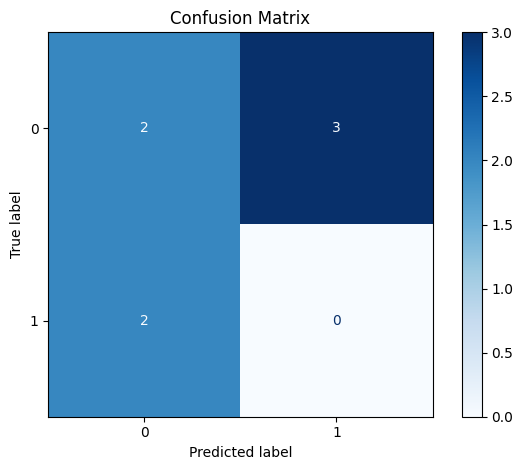

In [8]:
plot_confusion(y_test_c, y_pred_c, labels=[0, 1])

## 6. Regression: Forecasting Price Change
Train a linear regression model on the FFT features and evaluate.

In [9]:
reg = PriceChangeRegressor()
reg.fit(X_train, y_train_r)
y_pred_r = reg.predict(X_test)
r2 = reg.score(X_test, y_test_r)
print(f"Regression R² score: {r2:.3f}")

Regression R² score: -8.298


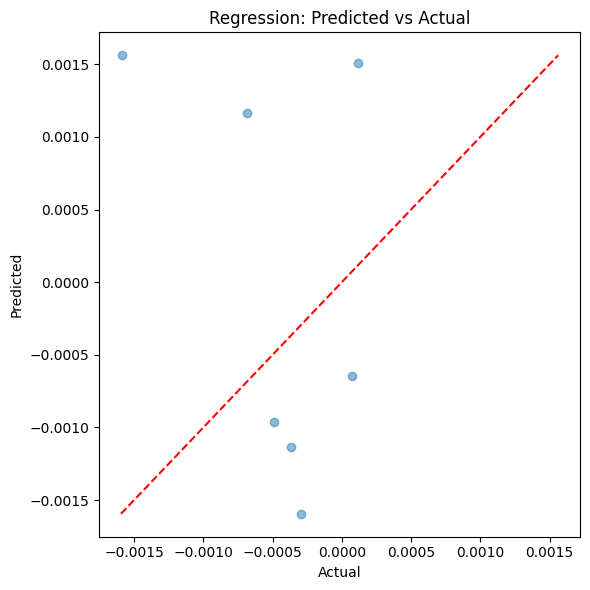

In [10]:
plot_regression(y_test_r, y_pred_r)

**Next:** Proceed to `04_clustering_and_pca.ipynb` for unsupervised exploration of these FFT features.